In [51]:
!pip install boruta --quiet
!pip install --force-reinstall --no-deps scikit-learn==1.3.2 imbalanced-learn==0.11.0 --quiet
!pip install shap --quiet

In [52]:
import kagglehub

# Import numerical computing library for fast array operations
import numpy as np

# Library for working with datasets in table-like structures
import pandas as pd

# brings in a utility to manage alert messages
import warnings

# Tool to apply different preprocessing to specific column types
from sklearn.compose import ColumnTransformer

# Classification model based on ensemble of decision trees
from sklearn.ensemble import RandomForestClassifier

# Handles missing data using simple strategies like mean or median
from sklearn.impute import SimpleImputer

# Functions to evaluate how well the model performs on classification tasks
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Splits data into training and testing sets for model evaluation
from sklearn.model_selection import train_test_split

# Chains preprocessing and modeling steps together into one pipeline
from sklearn.pipeline import Pipeline

# Encodes labels and scales numerical data for model compatibility
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Library for basic plotting and data visualization
import matplotlib.pyplot as plt  # corrected name from `matplib` to `plt`

# High-level interface for attractive and informative visualizations
import seaborn as sns

# Technique to balance imbalanced classes by synthetically generating samples
from imblearn.over_sampling import SMOTE

# Redundant import; already included above
# from sklearn.model_selection import train_test_split

# Neural network architecture for building deep learning models
from tensorflow.keras.models import Sequential

# Layers for adding neurons and controlling overfitting in neural networks
from tensorflow.keras.layers import Dense, Dropout, Input

# Optimizer that adjusts learning rate and weights during training
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Another ensemble method for classification using boosting of weak learners
from sklearn.ensemble import GradientBoostingClassifier

# Additional metrics for model performance, especially useful in imbalanced datasets
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score

# Shows how predicted values compare with actual values in matrix form
from sklearn.metrics import confusion_matrix

# Tools to evaluate model’s ability to distinguish between classes
from sklearn.metrics import roc_curve, auc

# Plots that show trade-off between precision and recall at different thresholds
from sklearn.metrics import precision_recall_curve

# brings in a specialized tool for identifying which parts of  input are most important
from boruta import BorutaPy

import shap

# load dataset

In [53]:
# Download latest version
path = kagglehub.dataset_download("daniaherzalla/tii-ssrc-23")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tii-ssrc-23


In [54]:
# Load a limited portion of the dataset from the correct path
TII_SSRC_23_DFILE = pd.read_csv("/kaggle/input/tii-ssrc-23/csv/data.csv", nrows=20000)

# Confirm successful data import
print(f"Data imported! Total rows and columns: {TII_SSRC_23_DFILE.shape}")

# Preview the top records
TII_SSRC_23_DFILE.head()

Data imported! Total rows and columns: (20000, 86)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Traffic Type,Traffic Subtype
0,192.168.1.90-192.168.1.3-53930-64738-6,192.168.1.90,53930.0,192.168.1.3,64738,6.0,01/01/1970 07:41:46 AM,52601173.0,1701.0,1793.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio
1,192.168.1.3-192.168.1.90-64738-37700-6,192.168.1.3,64738.0,192.168.1.90,37700,6.0,01/01/1970 07:41:46 AM,119106942.0,36.0,57.0,...,3.416174e+06,19996926.0,14078617.0,5001511.0,1737.400069,5003516.0,5000449.0,Benign,Audio,Audio
2,192.168.1.3-192.168.1.90-22-40854-6,192.168.1.3,22.0,192.168.1.90,40854,6.0,01/01/1970 07:41:46 AM,5589.0,1.0,1.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio
3,192.168.1.70-192.168.1.3-55422-64738-6,192.168.1.70,55422.0,192.168.1.3,64738,6.0,01/01/1970 07:41:47 AM,118166562.0,3932.0,4196.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio
4,192.168.1.90-192.168.1.3-59658-64738-17,192.168.1.90,59658.0,192.168.1.3,64738,17.0,01/01/1970 07:41:50 AM,119988385.0,25.0,6795.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,Audio,Audio


In [55]:
TII_SSRC_23_DFILE["Label"].value_counts()

,count
Label,
Malicious,19778
Benign,222


In [56]:
TII_SSRC_23_DFILE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow ID                     20000 non-null  object 
 1   Src IP                      20000 non-null  object 
 2   Src Port                    20000 non-null  float64
 3   Dst IP                      20000 non-null  object 
 4   Dst Port                    20000 non-null  int64  
 5   Protocol                    20000 non-null  float64
 6   Timestamp                   20000 non-null  object 
 7   Flow Duration               20000 non-null  float64
 8   Total Fwd Packet            20000 non-null  float64
 9   Total Bwd packets           20000 non-null  float64
 10  Total Length of Fwd Packet  20000 non-null  float64
 11  Total Length of Bwd Packet  20000 non-null  float64
 12  Fwd Packet Length Max       20000 non-null  float64
 13  Fwd Packet Length Min       200

In [57]:
TII_SSRC_23_DFILE.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.00000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,...,20000.000000,20000.000000,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,45888.836650,1502.845800,13.258800,5.141182e+06,32.65615,42.780450,1449.442050,1.876852e+04,95.247750,42.185050,...,12.576000,15.987000,1.068968e+05,2.661614e+04,1.308442e+05,8.724880e+04,2.204198e+06,7.557954e+04,2.266019e+06,2.150151e+06
std,10781.956945,8748.539317,5.240124,1.199070e+07,263.94388,372.464875,17683.992402,1.662854e+05,227.912203,127.661825,...,162.864986,11.332884,2.003865e+06,9.363262e+05,2.510146e+06,1.786916e+06,5.369668e+06,1.356718e+06,5.772352e+06,5.166990e+06
min,0.000000,0.000000,0.000000,1.800000e+01,1.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,39469.750000,23.000000,6.000000,5.460750e+03,1.00000,1.000000,39.000000,4.100000e+01,19.000000,0.000000,...,0.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,46401.500000,53.000000,17.000000,1.025100e+04,1.00000,1.000000,45.000000,4.800000e+01,44.000000,41.000000,...,0.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,54089.500000,53.000000,17.000000,1.003029e+07,3.00000,2.000000,83.000000,1.000000e+02,50.000000,46.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,64738.000000,64738.000000,17.000000,1.199996e+08,5722.00000,8535.000000,519561.000000,1.673935e+06,1348.000000,1348.000000,...,5015.000000,44.000000,8.531760e+07,7.069981e+07,9.998708e+07,8.531760e+07,1.151276e+08,6.685070e+07,1.151276e+08,1.151276e+08


In [58]:
TII_SSRC_23_DFILE.isnull().sum()

,0
Flow ID,0
Src IP,0
Src Port,0
Dst IP,0
Dst Port,0
...,...
Idle Max,0
Idle Min,0
Label,0
Traffic Type,0


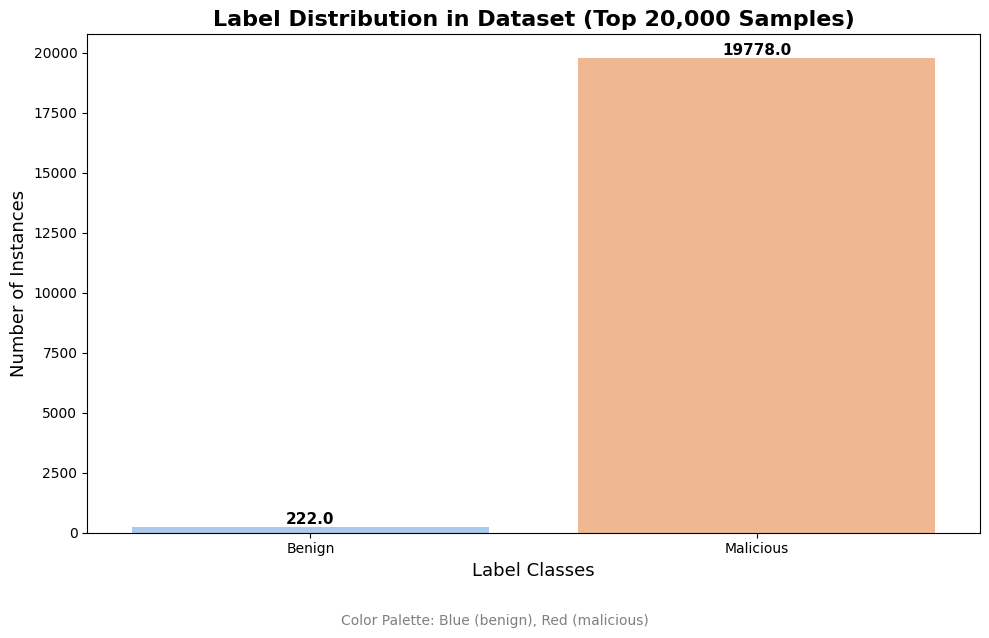

In [59]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 6))

# Custom color palette: blue for benign, red for malicious
custom_palette = ["#A1C9F4", "#FFB482"]  # adjust to your liking

ax = sns.countplot(
    x="Label",
    data=TII_SSRC_23_DFILE,
    palette=custom_palette
)

# Add count annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')

plt.title("Label Distribution in Dataset (Top 20,000 Samples)", fontsize=16, fontweight='bold')
plt.xlabel("Label Classes", fontsize=13)
plt.ylabel("Number of Instances", fontsize=13)

# Optional note under the chart
plt.figtext(0.5, -0.05, "Color Palette: Blue (benign), Red (malicious)",
            wrap=True, horizontalalignment='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()


In [60]:
TII_SSRC_23_DFILE = TII_SSRC_23_DFILE.drop(['Flow ID', 'Timestamp', 'Src IP', 'Dst IP'], axis=1)

In [61]:
# Initialize the label encoder for converting text categories to numeric codes
encoder = LabelEncoder()

# Encode the 'Label' column (e.g., benign/malicious) into numeric format
TII_SSRC_23_DFILE["Label"] = encoder.fit_transform(TII_SSRC_23_DFILE["Label"])

# Encode the 'Traffic Type' column into corresponding numeric categories
TII_SSRC_23_DFILE["Traffic Type"] = encoder.fit_transform(TII_SSRC_23_DFILE["Traffic Type"])

# Encode the 'Traffic Subtype' column similarly into numeric values
TII_SSRC_23_DFILE["Traffic Subtype"] = encoder.fit_transform(TII_SSRC_23_DFILE["Traffic Subtype"])

# Display the first few rows to verify successful encoding
TII_SSRC_23_DFILE.head()


,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Traffic Type,Traffic Subtype
0,53930.0,64738,6.0,52601173.0,1701.0,1793.0,149935.0,140566.0,1318.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0
1,64738.0,37700,6.0,119106942.0,36.0,57.0,1280.0,1650.0,41.0,0.0,...,3.416174e+06,19996926.0,14078617.0,5001511.0,1737.400069,5003516.0,5000449.0,0,0,0
2,22.0,40854,6.0,5589.0,1.0,1.0,124.0,0.0,124.0,124.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0
3,55422.0,64738,6.0,118166562.0,3932.0,4196.0,403875.0,301478.0,1348.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0
4,59658.0,64738,17.0,119988385.0,25.0,6795.0,225.0,534811.0,9.0,9.0,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0


In [62]:
# Separate features (X) and target (y) for model training
X_full = TII_SSRC_23_DFILE.drop('Label', axis=1)  # Remove the target column
y_labels = TII_SSRC_23_DFILE['Label']             # Store the target labels

# Get the list of all feature names before selection
all_features = X_full.columns.tolist()

# Initialize a Random Forest model for use in Boruta feature selection
rf_estimator = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    class_weight='balanced',
    max_depth=5
)

# Set up Boruta for feature selection with a custom number of trees
boruta_selector = BorutaPy(
    estimator=rf_estimator,
    n_estimators=40,
    verbose=2,
    random_state=42
)

# Fit Boruta on the full dataset (features and target)
boruta_selector.fit(X_full.values, y_labels.values)

# Identify which features were selected (True/False mask)
selected_mask = boruta_selector.support_

# Retrieve the rank of each feature
feature_rankings = boruta_selector.ranking_

# Filter and store only the selected feature names
important_features = X_full.columns[selected_mask].tolist()

# Display results
print("\nBoruta Feature Selection Results:")
print(f"Selected {len(important_features)} features: {important_features}")

print("\nFeature Rankings:")
for feature, rank in zip(all_features, feature_rankings):
    print(f"{feature}: Rank {rank}")

# Create a new DataFrame with only the selected features
X_filtered = X_full[important_features]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	81
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	52
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	52
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	52
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	52
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	30
Tentative: 	41
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	30
Tentative: 	41
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	30
Tentative: 	41
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	30
Tentative: 	41
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	34
Tentative: 	

#Correlation Heatmap

In [74]:
# Show preview of the refined dataset
print("\nPreview of dataset with selected features:")
X_filtered.head()


Preview of dataset with selected features:


,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Segment Size Avg,Bwd Segment Size Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Traffic Type,Traffic Subtype
0,53930.0,64738,6.0,52601173.0,1701.0,1793.0,149935.0,140566.0,1318.0,0.0,...,88.145209,78.397100,72603.0,603.0,7187.0,65280.0,1206.0,32.0,0,0
1,64738.0,37700,6.0,119106942.0,36.0,57.0,1280.0,1650.0,41.0,0.0,...,35.555556,28.947368,182.0,4.0,157.0,502.0,31.0,32.0,0,0
2,22.0,40854,6.0,5589.0,1.0,1.0,124.0,0.0,124.0,124.0,...,124.000000,0.000000,0.0,0.0,0.0,501.0,0.0,32.0,0,0
3,55422.0,64738,6.0,118166562.0,3932.0,4196.0,403875.0,301478.0,1348.0,0.0,...,102.714903,71.848904,100716.0,764.0,7317.0,65280.0,2770.0,32.0,0,0
4,59658.0,64738,17.0,119988385.0,25.0,6795.0,225.0,534811.0,9.0,9.0,...,9.000000,78.706549,76426.0,973.0,5507.0,0.0,24.0,8.0,0,0


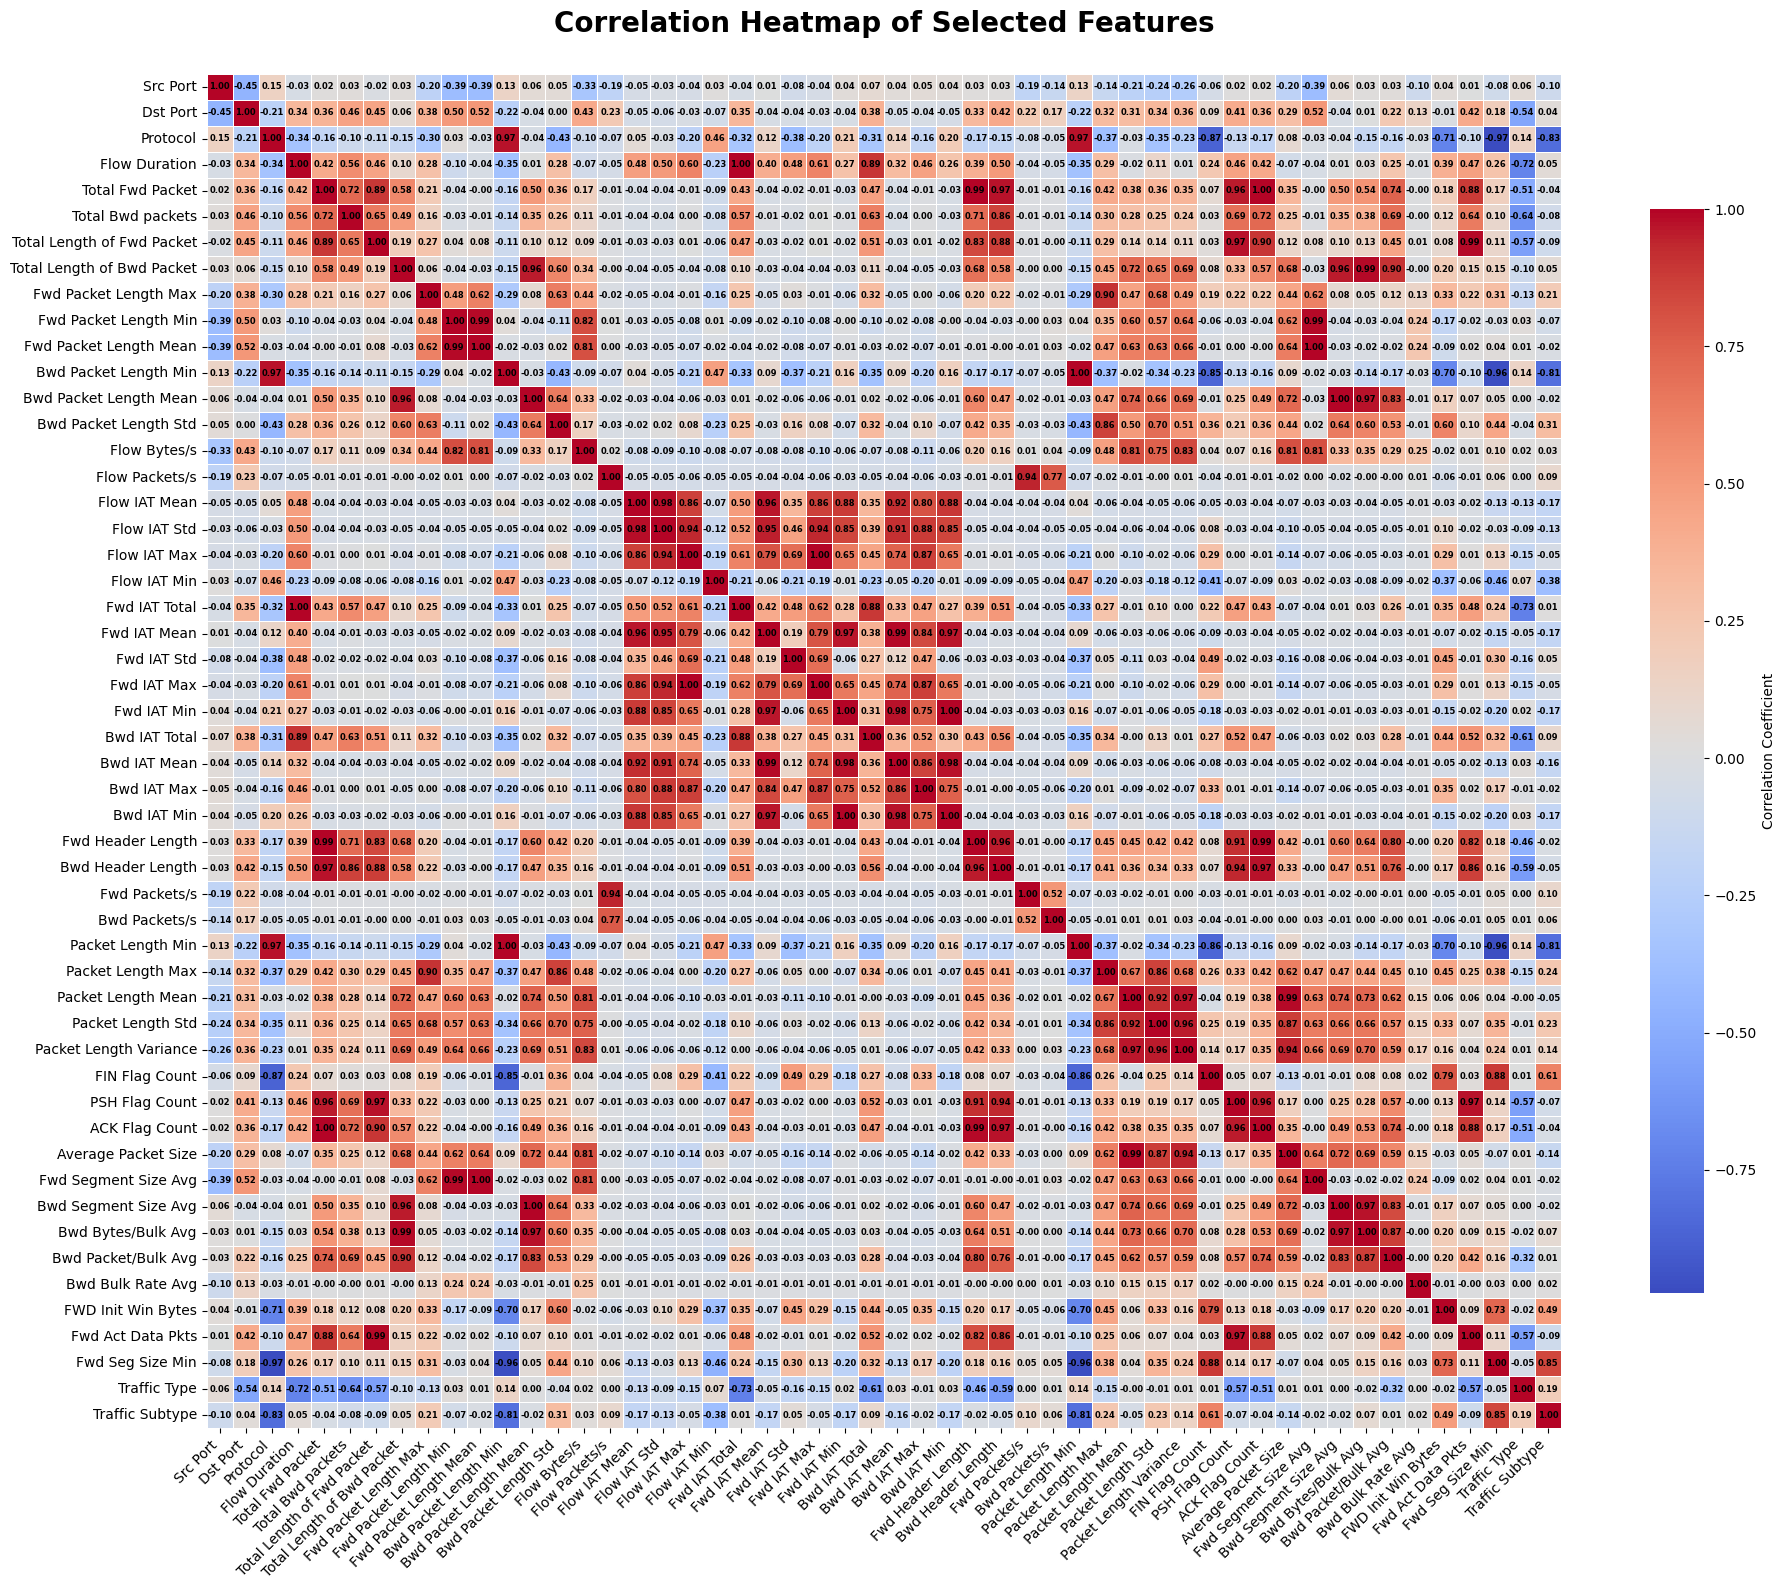

In [75]:
# Set the figure size
plt.figure(figsize=(20, 16))

# Generate the correlation matrix
correlation_matrix = X_filtered.corr(numeric_only=True)

# Plot the full matrix without masking
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
    annot_kws={"size": 6, "weight": "bold", "color": "black"}
)

# Add title and formatting
plt.title("Correlation Heatmap of Selected Features", fontsize=20, fontweight='bold', pad=30)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Layout adjustment
plt.tight_layout()
plt.show()

Boxplot of Key Features vs. Traffic Type:

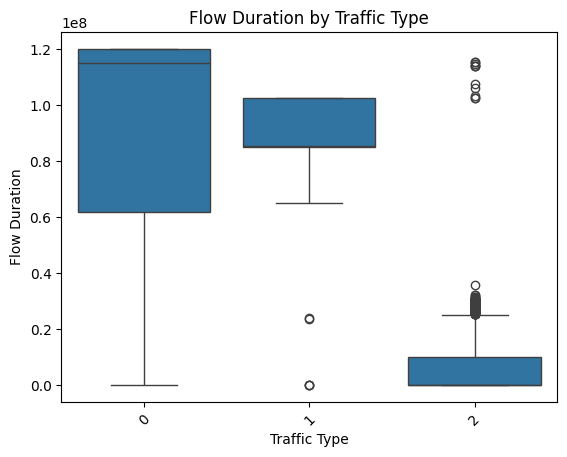

In [76]:
# Create a boxplot showing the distribution of flow duration for each traffic type
sns.boxplot(x="Traffic Type", y="Flow Duration", data=TII_SSRC_23_DFILE)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title to the plot
plt.title("Flow Duration by Traffic Type")

# Display the plot
plt.show()



Shape of original data: (20000, 52)
Shape of resampled data: (39556, 52)

New Label Distribution:
Label
0    19778
1    19778
Name: count, dtype: int64


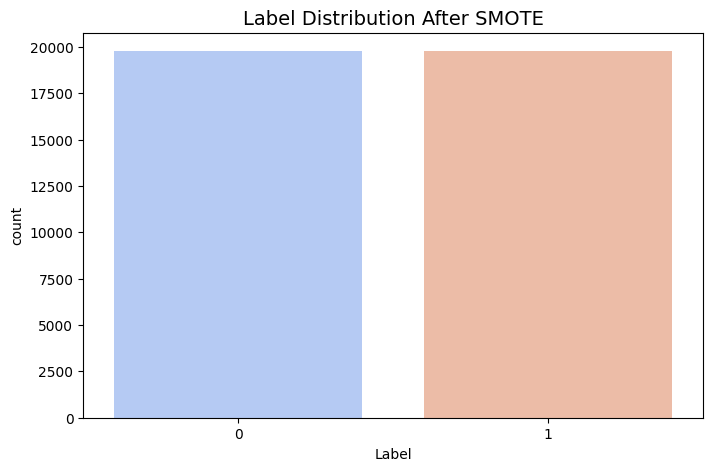

In [77]:
# Suppress non-critical warning messages to keep output clean
warnings.filterwarnings("ignore")

# Initialize SMOTE to synthesize minority class examples
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the filtered features and their corresponding labels
X_resampled, y_resampled = smote.fit_resample(X_filtered, y_labels)

# Display shape of original and resampled datasets
print("\nShape of original data:", X_filtered.shape)
print("Shape of resampled data:", X_resampled.shape)

# Display new class distribution after resampling
print("\nNew Label Distribution:")
print(y_resampled.value_counts())

# Set up the plot to show class balance
plt.figure(figsize=(8, 5))

# Draw a count plot to visualize balanced label distribution
sns.countplot(x=y_resampled, palette="coolwarm")

# Add a title to the count plot
plt.title("Label Distribution After SMOTE", fontsize=14)

# Show the plot
plt.show()


# Data splitting

In [78]:
# Initialize a scaler to normalize feature values across the same range
scaler = StandardScaler()

# Fit the scaler to the resampled features and transform them
X_scaled = scaler.fit_transform(X_resampled)

# Wrap the scaled values into a new DataFrame with original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X_resampled.columns)

# Show a message before displaying the scaled data
print("\nScaled features using StandardScaler:")

# Preview the top rows of the scaled feature set
X_scaled_df.head()

# Split the scaled data into training and testing sets (keeping class balance intact)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

# Confirm the split with shape summaries
print("\nData split into training and testing sets:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



Scaled features using StandardScaler:

Data split into training and testing sets:
X_train shape: (31644, 52)
X_test shape: (7912, 52)
y_train shape: (31644,)
y_test shape: (7912,)


#DeepFeatureNet-GB Hybrid Classifier Model


In [79]:
# Get the number of distinct output classes for classification
num_classes = y_train.nunique()

# Initialize a sequential neural network model
model = Sequential()

# Add the first dense (fully connected) layer with ReLU activation
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Add dropout to prevent overfitting by randomly disabling 30% of the neurons
model.add(Dropout(0.3))

# Add a second dense layer with fewer neurons and ReLU activation
model.add(Dense(64, activation='relu'))

# Add another dropout layer with a lower dropout rate
model.add(Dropout(0.2))

# Print a summary of the model's architecture and parameters
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,040 (58.75 KB)

 Trainable params: 15,040 (58.75 KB)

 Non-trainable params: 0 (0.00 B)

## Extract Features

In [80]:
# Generate output feature representations for the training set using the trained model
X_train_features = model.predict(X_train)

# Generate output feature representations for the test set using the same model
X_test_features = model.predict(X_test)

989/989 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#GradientBoostingClassifier

In [81]:
# Initialize Gradient Boosting model with specific parameters for controlled learning
gb_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.001, max_depth=30, random_state=42)

# Train the Gradient Boosting model using the extracted training features and target labels
gb_model.fit(X_train_features, y_train)

# Predict the output categories for the unseen test feature representations
y_pred_gb = gb_model.predict(X_test_features)

# Get the probability estimates for the positive class predictions
y_pred_proba_gb = gb_model.predict_proba(X_test_features)[:, 1]


#TRAIN RESULTS

In [82]:
# Utilize trained model to predict categories for training data
y_pred_gb_train = gb_model.predict(X_train_features)

# Extract predicted probabilities for positive class only for training data
y_pred_proba_gb_train = gb_model.predict_proba(X_train_features)[:, 1]

# Calculate accuracy of predictions on training samples
train_accuracy_gb = accuracy_score(y_train, y_pred_gb_train)

# Calculate precision score to measure exactness of positive predictions
train_precision_gb = precision_score(y_train, y_pred_gb_train)

# Calculate recall score to measure completeness of positive predictions
train_recall_gb = recall_score(y_train, y_pred_gb_train)

# Calculate F1 score as harmonic mean of precision and recall
train_f1_gb = f1_score(y_train, y_pred_gb_train)

# Calculate Area Under Curve (AUC) score to check quality of ranking
train_auc_gb = roc_auc_score(y_train, y_pred_proba_gb_train)

# Display heading to indicate evaluation results for training data
print("Gradient Boosting Classifier - Training Evaluation Metrics")

# Display calculated accuracy value for training set
print("Accuracy:", train_accuracy_gb)

# Display calculated precision value for training set
print("Precision:", train_precision_gb)

# Display calculated recall value for training set
print("Recall:", train_recall_gb)

# Display calculated F1 score value for training set
print("F1 Score:", train_f1_gb)

# Display calculated AUC value for training set
print("AUC Score:", train_auc_gb)


Gradient Boosting Classifier - Training Evaluation Metrics
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC Score: 1.0


In [83]:
# Classification Report for Gradient Boosting on Training Data
print("\nClassification Report (Gradient Boosting - Training Data):")

# Generate and display report using true vs predicted labels
print(classification_report(y_train, y_pred_gb_train))



Classification Report (Gradient Boosting - Training Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15822
           1       1.00      1.00      1.00     15822

    accuracy                           1.00     31644
   macro avg       1.00      1.00      1.00     31644
weighted avg       1.00      1.00      1.00     31644



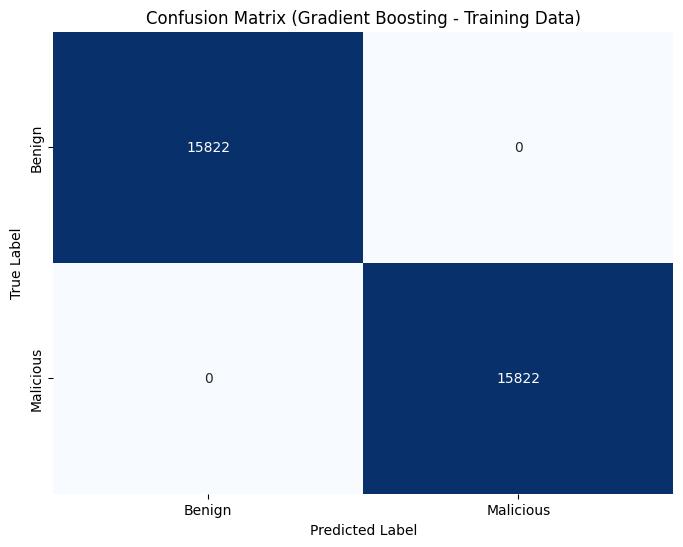

In [84]:
# Create a confusion matrix to show how predictions align with actual categories (Training Data)
cm_gb_train = confusion_matrix(y_train, y_pred_gb_train)

# Set up the figure size for the heatmap
plt.figure(figsize=(8, 6))

# Draw the confusion matrix heatmap
sns.heatmap(cm_gb_train, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])

# Add a title to the heatmap
plt.title('Confusion Matrix (Gradient Boosting - Training Data)')

# Label the X-axis as predicted output
plt.xlabel('Predicted Label')

# Label the Y-axis as actual/true values
plt.ylabel('True Label')

# Show the final heatmap
plt.show()


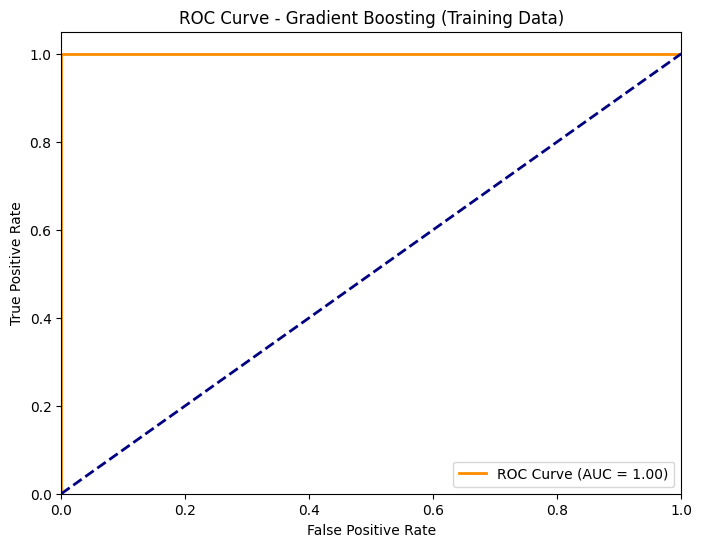

In [85]:
# Compute False Positive Rate, True Positive Rate, and thresholds for ROC (Training Data)
fpr_gb_train, tpr_gb_train, thresholds_gb_train = roc_curve(y_train, y_pred_proba_gb_train)

# Calculate the Area Under the Curve (AUC) score
roc_auc_gb_train = auc(fpr_gb_train, tpr_gb_train)

# Set up the plot size
plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr_gb_train, tpr_gb_train, color='darkorange', lw=2,
         label='ROC Curve (AUC = %0.2f)' % roc_auc_gb_train)

# Plot a diagonal baseline (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Label the axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set plot title
plt.title('ROC Curve - Gradient Boosting (Training Data)')

# Add legend
plt.legend(loc="lower right")

# Show the final plot
plt.show()

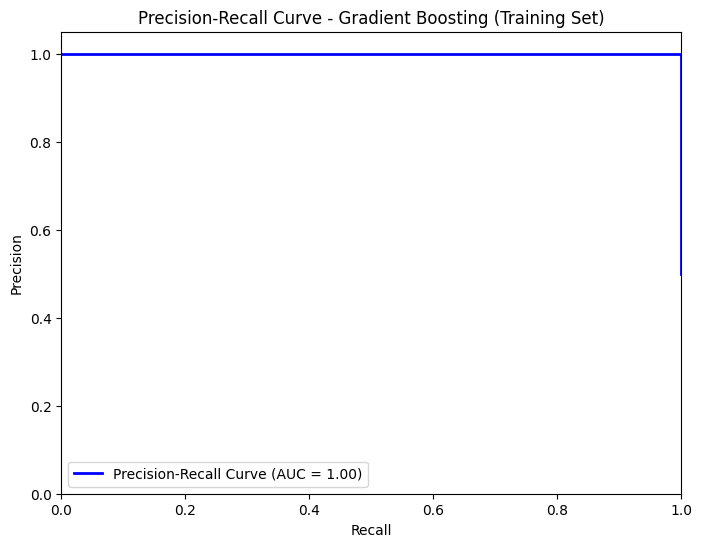

In [86]:
# Compute precision, recall, and thresholds for training predictions
precision_gb_train, recall_gb_train, thresholds_pr_gb_train = precision_recall_curve(
    y_train, y_pred_proba_gb_train
)

# Calculate Area Under the Precision-Recall Curve (AUPRC)
auprc_gb_train = auc(recall_gb_train, precision_gb_train)

# Set up the visual layout size
plt.figure(figsize=(8, 6))

# Plot the Precision-Recall curve
plt.plot(recall_gb_train, precision_gb_train, color='blue', lw=2,
         label='Precision-Recall Curve (AUC = %0.2f)' % auprc_gb_train)

# Label axes
plt.xlabel('Recall')
plt.ylabel('Precision')

# Set title
plt.title('Precision-Recall Curve - Gradient Boosting (Training Set)')

# Add legend
plt.legend(loc="lower left")

# Set plot limits
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Show the final plot
plt.show()


#TEST RESULTS

In [87]:
# Evaluate Gradient Boosting model on the test data
gb_test_accuracy = accuracy_score(y_test, y_pred_gb)             # Overall correctness
gb_test_precision = precision_score(y_test, y_pred_gb)           # Exactness of positive predictions
gb_test_recall = recall_score(y_test, y_pred_gb)                 # Ability to find all positive cases
gb_test_f1 = f1_score(y_test, y_pred_gb)                         # Balance of precision and recall
gb_test_auc = roc_auc_score(y_test, y_pred_proba_gb)             # Ranking quality via AUC

# Display evaluation results
print("\nGradient Boosting Model - Test Set Metrics:")
print("Accuracy:", gb_test_accuracy)
print("Precision:", gb_test_precision)
print("Recall:", gb_test_recall)
print("F1 Score:", gb_test_f1)
print("AUC Score:", gb_test_auc)



Gradient Boosting Model - Test Set Metrics:
Accuracy: 0.999747219413549
Precision: 0.9994946942900454
Recall: 1.0
F1 Score: 0.9997472832954258
AUC Score: 0.9998736097067745


In [88]:
# Classification Report
print("\nClassification Report (Gradient Boosting - Test Set):")
print(classification_report(y_test, y_pred_gb))



Classification Report (Gradient Boosting - Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3956
           1       1.00      1.00      1.00      3956

    accuracy                           1.00      7912
   macro avg       1.00      1.00      1.00      7912
weighted avg       1.00      1.00      1.00      7912



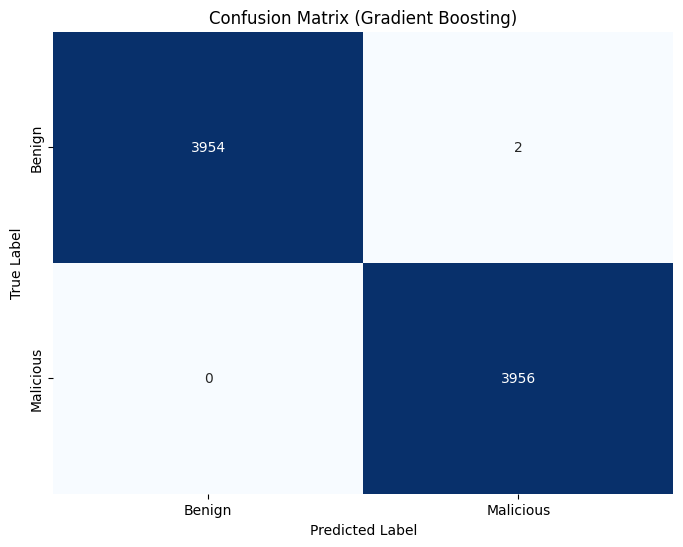

In [89]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_gb)  # Compare true vs predicted labels

# Set visual layout size of the plot
plt.figure(figsize=(8, 6))

# Draw heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])

# Set the title of the plot
plt.title('Confusion Matrix (Gradient Boosting)')

# Label horizontal axis
plt.xlabel('Predicted Label')

# Label vertical axis
plt.ylabel('True Label')

# Show the final plot
plt.show()


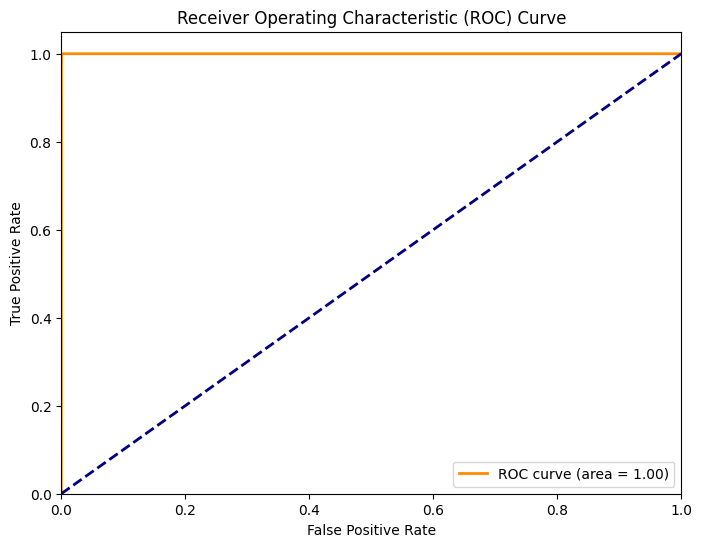

In [90]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gb)  # Evaluate classification trade-offs

# Calculate Area Under the Curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)  # ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal baseline

# Axis configuration
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Titles and labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()


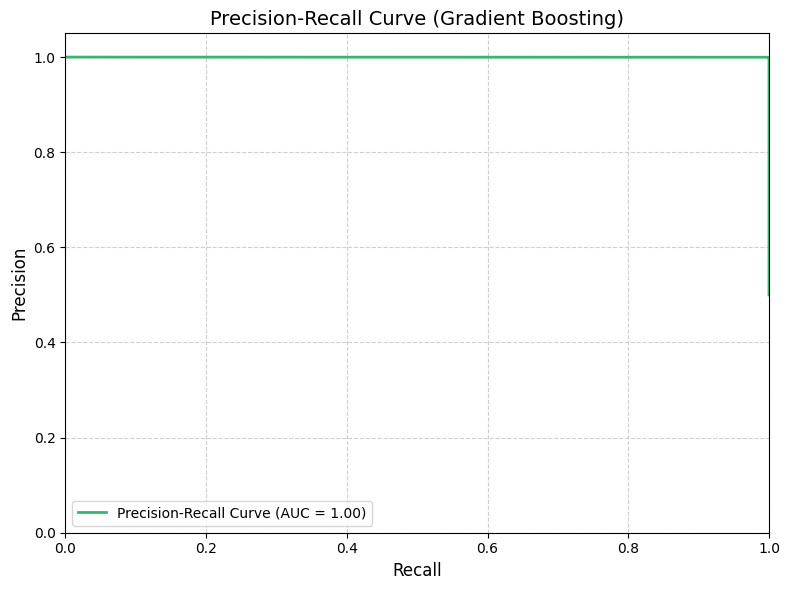

In [91]:
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_gb)

# Compute AUPRC (Area Under the Precision-Recall Curve)
auprc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='mediumseagreen', lw=2,
         label='Precision-Recall Curve (AUC = %0.2f)' % auprc)

# Axis labels and title
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve (Gradient Boosting)', fontsize=14)
plt.legend(loc="lower left", fontsize=10)

# Axis limits and grid
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# --- SHAP Plots ---


Generating SHAP Summary Plot:


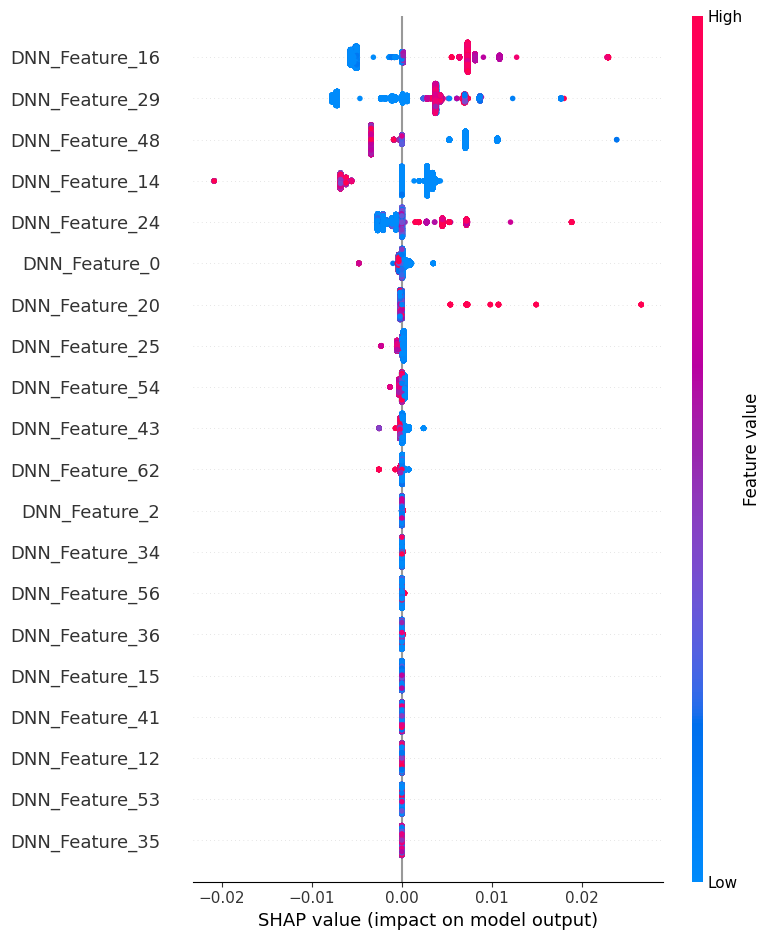


Generating SHAP Dependence Plot for: DNN_Feature_0


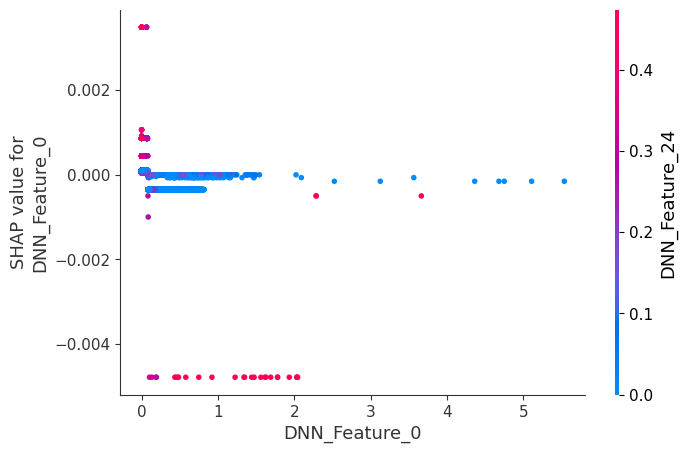

In [92]:
# Ensure X_test_features is a DataFrame with proper column names
dnn_feature_names = [f'DNN_Feature_{i}' for i in range(X_test_features.shape[1])]
X_test_features_df = pd.DataFrame(X_test_features, columns=dnn_feature_names)

# Use a sample from the test features as background data (ensure it's also a DataFrame)
background_data = shap.sample(X_test_features_df, 100)

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(gb_model, data=background_data)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_features_df)

# --- SHAP Summary Plot ---
print("\nGenerating SHAP Summary Plot:")
if isinstance(shap_values, list):  # multi-class case
    shap.summary_plot(shap_values[1], X_test_features_df, feature_names=dnn_feature_names)
else:  # binary classification case
    shap.summary_plot(shap_values, X_test_features_df, feature_names=dnn_feature_names)

# --- SHAP Dependence Plot ---
if X_test_features_df.shape[1] > 0:
    feature_idx_to_plot = 0  # Index of feature to plot
    feature_name_to_plot = dnn_feature_names[feature_idx_to_plot]
    print(f"\nGenerating SHAP Dependence Plot for: {feature_name_to_plot}")
    if isinstance(shap_values, list):
        shap.dependence_plot(feature_idx_to_plot, shap_values[1], X_test_features_df,
                             feature_names=dnn_feature_names, interaction_index="auto")
    else:
        shap.dependence_plot(feature_idx_to_plot, shap_values, X_test_features_df,
                             feature_names=dnn_feature_names, interaction_index="auto")
else:
    print("\nCould not generate Dependence Plot: No DNN features available.")

#CNN MODEL

In [93]:

# Reshape data for CNN by adding a channel dimension
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print the new shapes
print("\nReshaped data for CNN:")
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

# Build the CNN model
cnn_model = Sequential([
    Input(shape=(X_train_cnn.shape[1], 1)),  # Explicit input layer

    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Force model to build for SHAP (optional safety)
_ = cnn_model.predict(np.expand_dims(X_train_cnn[0], axis=0))

# Model Summary
cnn_model.summary()


Reshaped data for CNN:
X_train_cnn shape: (31644, 52, 1)
X_test_cnn shape: (7912, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 23, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,705 (377.75 KB)

 Trainable params: 96,705 (377.75 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Train the CNN model
history = cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_data=(X_test_cnn, y_test))


Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9780 - loss: 0.0762 - val_accuracy: 0.9980 - val_loss: 0.0047
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9986 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 0.9999 - val_loss: 4.9750e-04
Epoch 4/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9995 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 7.1751e-04
Epoch 5/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9998 - loss: 4.5101e-04 - val_accuracy: 0.9991 - val_loss: 0.0033


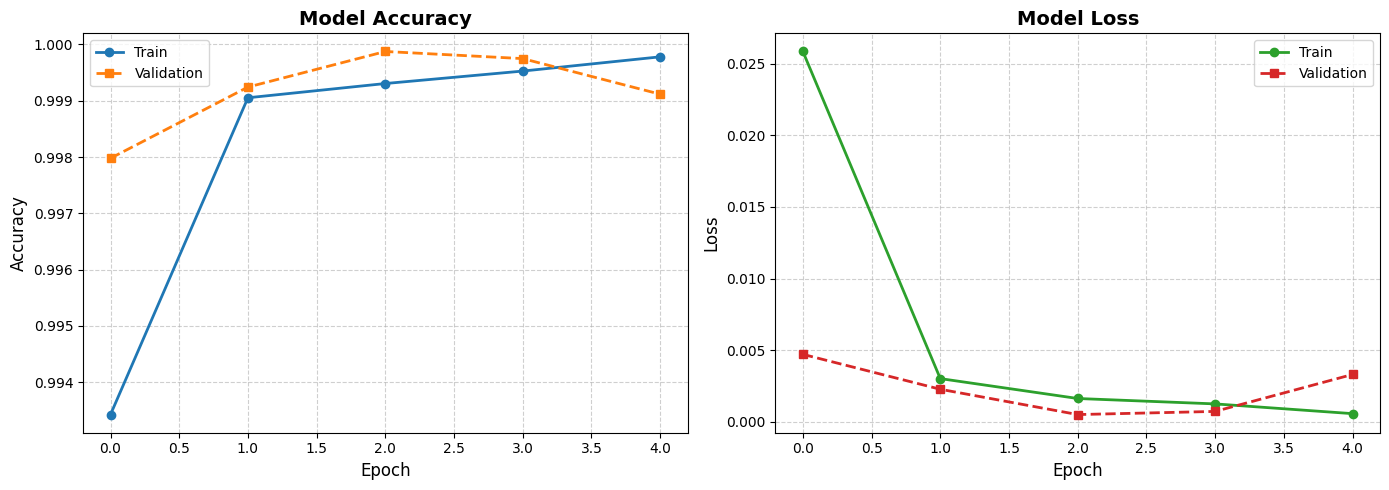

In [95]:
# Plot Accuracy and Loss Side-by-Side
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Accuracy Plot
axs[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=6, label='Train')
axs[0].plot(history.history['val_accuracy'], marker='s', linestyle='--', color='#ff7f0e', linewidth=2, markersize=6, label='Validation')
axs[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Accuracy', fontsize=12)
axs[0].legend(fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.6)

# Loss Plot
axs[1].plot(history.history['loss'], marker='o', linestyle='-', color='#2ca02c', linewidth=2, markersize=6, label='Train')
axs[1].plot(history.history['val_loss'], marker='s', linestyle='--', color='#d62728', linewidth=2, markersize=6, label='Validation')
axs[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [96]:
# Evaluate the CNN model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)

# Display the evaluation results
print("\nCNN Model Evaluation Results")
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")



CNN Model Evaluation Results
Test Loss     : 0.0033
Test Accuracy : 0.9991


#TRAIN RESULTS

In [97]:
# Generate predicted probabilities for the training set using CNN
y_train_pred_cnn_proba = cnn_model.predict(X_train_cnn).flatten()

# Convert probabilities to binary predictions using 0.5 threshold
y_train_pred_cnn = (y_train_pred_cnn_proba > 0.5).astype(int)

# Evaluate CNN model performance on the training set
accuracy_cnn_train = accuracy_score(y_train, y_train_pred_cnn)
precision_cnn_train = precision_score(y_train, y_train_pred_cnn)
recall_cnn_train = recall_score(y_train, y_train_pred_cnn)
f1_cnn_train = f1_score(y_train, y_train_pred_cnn)

# Display training metrics
print("\n CNN Model Performance on Training Set:")
print(f" Accuracy : {accuracy_cnn_train:.4f}")
print(f" Precision: {precision_cnn_train:.4f}")
print(f" Recall   : {recall_cnn_train:.4f}")
print(f" F1 Score : {f1_cnn_train:.4f}")


989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

 CNN Model Performance on Training Set:
 Accuracy : 0.9996
 Precision: 0.9991
 Recall   : 1.0000
 F1 Score : 0.9996


In [98]:
# Classification Report for CNN (Train Set)
print("\nClassification Report (CNN - Train Set):")
print(classification_report(y_train, y_train_pred_cnn))


Classification Report (CNN - Train Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15822
           1       1.00      1.00      1.00     15822

    accuracy                           1.00     31644
   macro avg       1.00      1.00      1.00     31644
weighted avg       1.00      1.00      1.00     31644



# Confusion Matrix for CNN

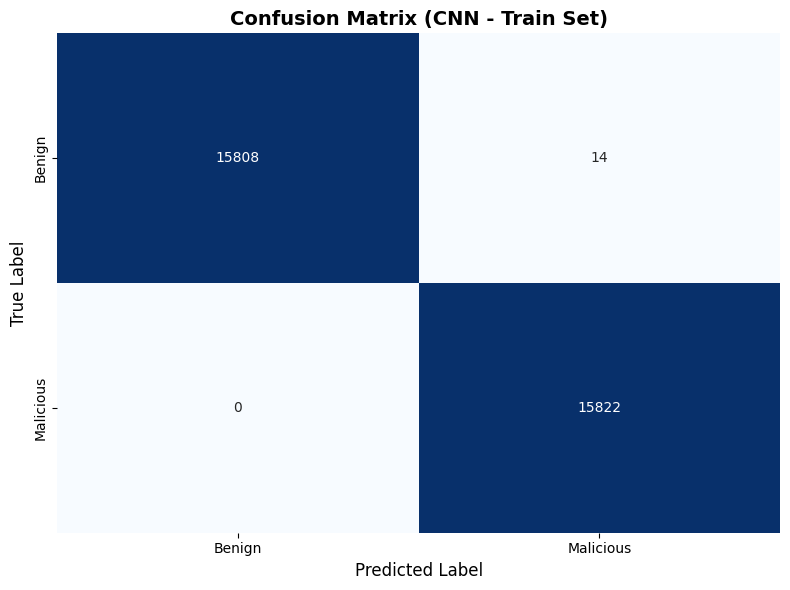

In [99]:
# Compute confusion matrix for CNN model on training set
cm_cnn = confusion_matrix(y_train, y_train_pred_cnn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix (CNN - Train Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

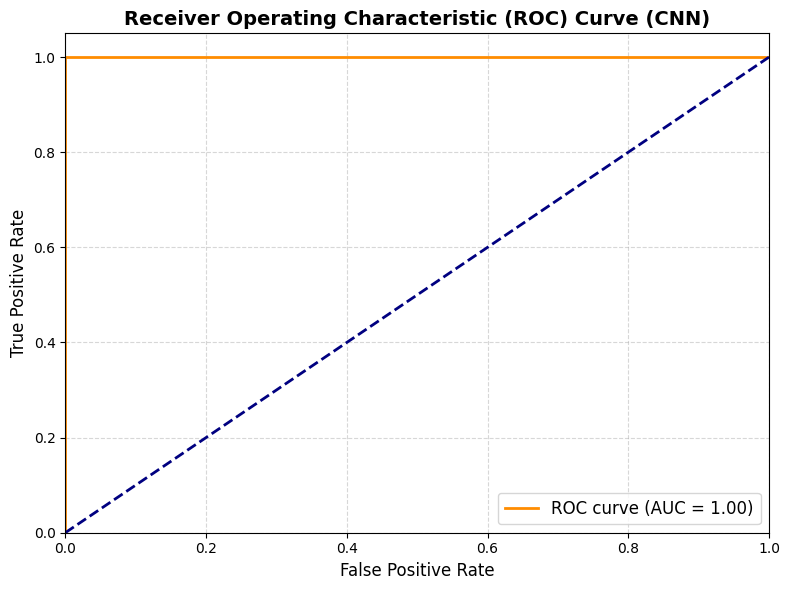

In [100]:
# Compute FPR, TPR, and thresholds using predicted probabilities
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_train, y_train_pred_cnn_proba)

# Compute the Area Under the Curve
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc_cnn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve (CNN)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


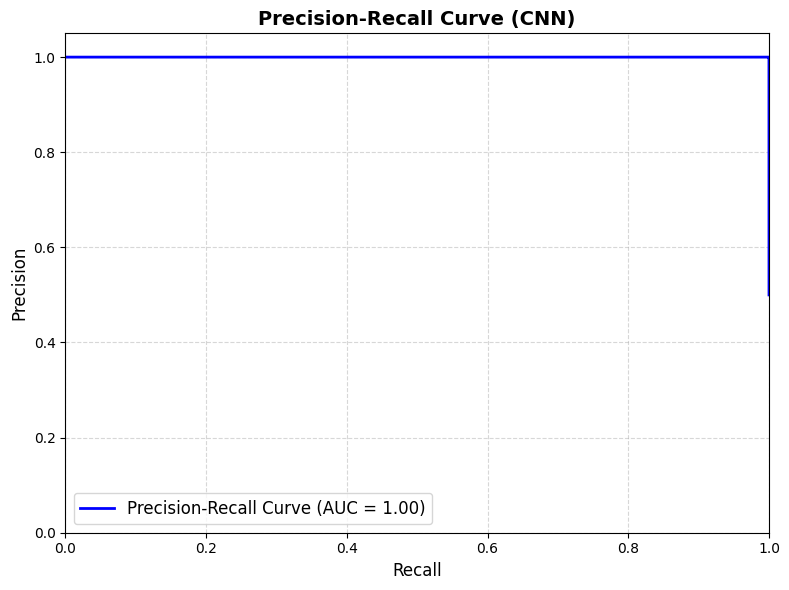

In [101]:
# Calculate precision, recall, and thresholds
precision_cnn, recall_cnn, thresholds_cnn_pr = precision_recall_curve(y_train, y_train_pred_cnn_proba)

# Compute Area Under Precision-Recall Curve
auprc_cnn = auc(recall_cnn, precision_cnn)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_cnn, precision_cnn, color='blue', lw=2,
         label='Precision-Recall Curve (AUC = %0.2f)' % auprc_cnn)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve (CNN)', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=12)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#TEST RESULTS

In [102]:
# Generate predicted probabilities from the CNN model for the test set
y_test_proba_cnn = cnn_model.predict(X_test_cnn).flatten()

# Convert probabilities into binary class labels using a threshold of 0.5
y_test_pred_cnn = (y_test_proba_cnn > 0.5).astype(int)

# Evaluate the CNN model performance on the test set
cnn_accuracy_test = accuracy_score(y_test, y_test_pred_cnn)
cnn_precision_test = precision_score(y_test, y_test_pred_cnn)
cnn_recall_test = recall_score(y_test, y_test_pred_cnn)
cnn_f1_test = f1_score(y_test, y_test_pred_cnn)

# Display the evaluation metrics
print("\n CNN Model Performance on Test Set:")
print(f" Accuracy : {cnn_accuracy_test:.4f}")
print(f" Precision: {cnn_precision_test:.4f}")
print(f" Recall   : {cnn_recall_test:.4f}")
print(f" F1 Score : {cnn_f1_test:.4f}")


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 CNN Model Performance on Test Set:
 Accuracy : 0.9991
 Precision: 0.9982
 Recall   : 1.0000
 F1 Score : 0.9991


In [103]:
# Make predictions and convert probabilities to binary class labels
y_proba_cnn_test = cnn_model.predict(X_test_cnn).flatten()
y_pred_cnn_test = (y_proba_cnn_test > 0.5).astype("int32")  # Threshold-based classification

# Print the classification report for CNN on the test set
print("\nClassification Report (CNN - Test Set):")
print(classification_report(y_test, y_pred_cnn_test))


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report (CNN - Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3956
           1       1.00      1.00      1.00      3956

    accuracy                           1.00      7912
   macro avg       1.00      1.00      1.00      7912
weighted avg       1.00      1.00      1.00      7912



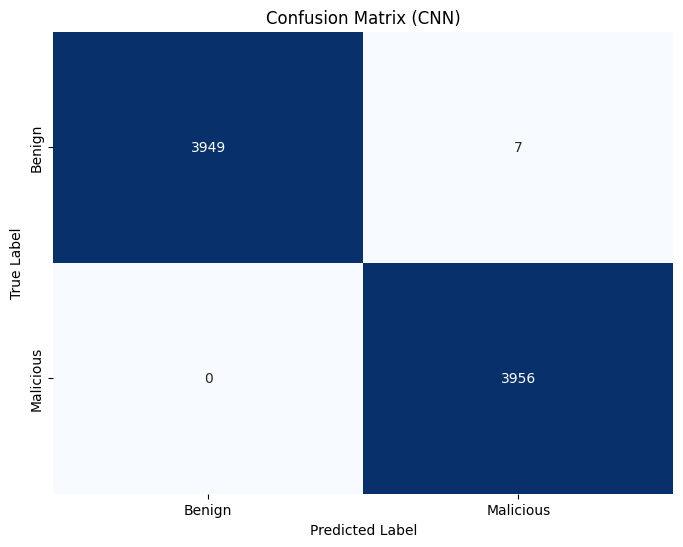

In [104]:
# Construct confusion matrix using true vs predicted labels from CNN model
cm_cnn = confusion_matrix(y_test, y_pred_cnn_test)

# Prepare the plotting area
plt.figure(figsize=(8, 6))

# Use seaborn heatmap to visually plot the confusion matrix
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])

# Add titles and axis labels
plt.title('Confusion Matrix (CNN)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the final plot
plt.show()


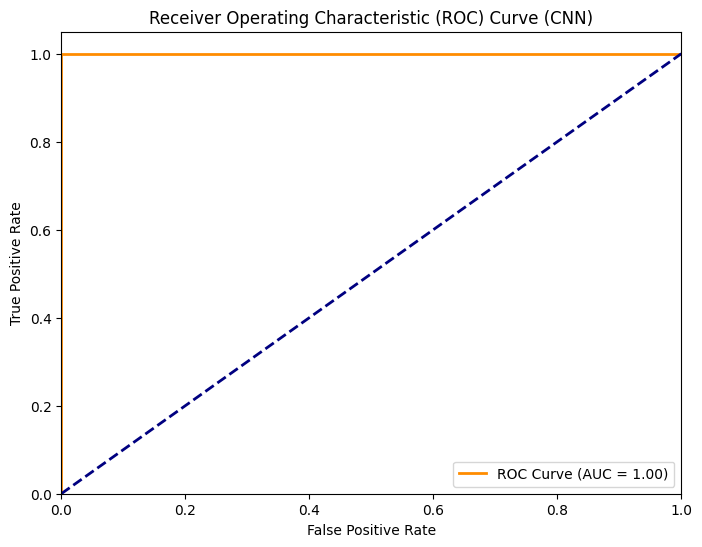

In [105]:
# Generate FPR, TPR, and thresholds using predicted probabilities from CNN
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_proba_cnn_test)

# Compute the Area Under the Curve (AUC) for performance evaluation
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Initialize the plot
plt.figure(figsize=(8, 6))

# Plot the ROC Curve
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2,
         label='ROC Curve (AUC = %0.2f)' % roc_auc_cnn)

# Plot a diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Label the axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add a title
plt.title('Receiver Operating Characteristic (ROC) Curve (CNN)')

# Add legend
plt.legend(loc="lower right")

# Show the ROC plot
plt.show()


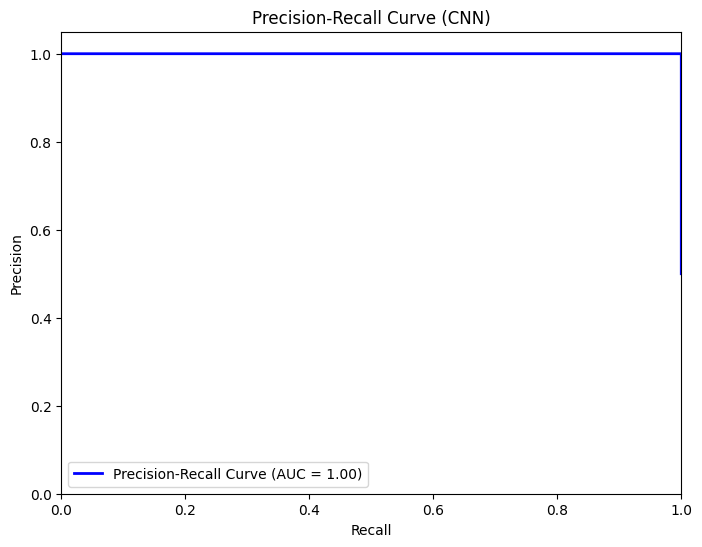

In [106]:
# CNN's Precision-Recall Curve

# Generate precision, recall, and thresholds using predicted probabilities
precision_cnn, recall_cnn, thresholds_cnn_pr = precision_recall_curve(y_test, y_proba_cnn_test)

# Compute the Area Under the Precision-Recall Curve
auprc_cnn = auc(recall_cnn, precision_cnn)

# Configure the plot's figure size
plt.figure(figsize=(8, 6))

# Plot the Precision-Recall curve
plt.plot(recall_cnn, precision_cnn, color='blue', lw=2,
         label='Precision-Recall Curve (AUC = %0.2f)' % auprc_cnn)

# Label the X-axis as Recall
plt.xlabel('Recall')

# Label the Y-axis as Precision
plt.ylabel('Precision')

# Add a title
plt.title('Precision-Recall Curve (CNN)')

# Add legend to the lower left corner
plt.legend(loc="lower left")

# Set Y-axis limits
plt.ylim([0.0, 1.05])

# Set X-axis limits
plt.xlim([0.0, 1.0])

# Display the complete plot
plt.show()



Calculating SHAP values for 1000 samples from test set...
SHAP values processed shape: (1000, 52)
DataFrame for plotting shape: (1000, 52)

Generating SHAP Summary Plot (CNN):


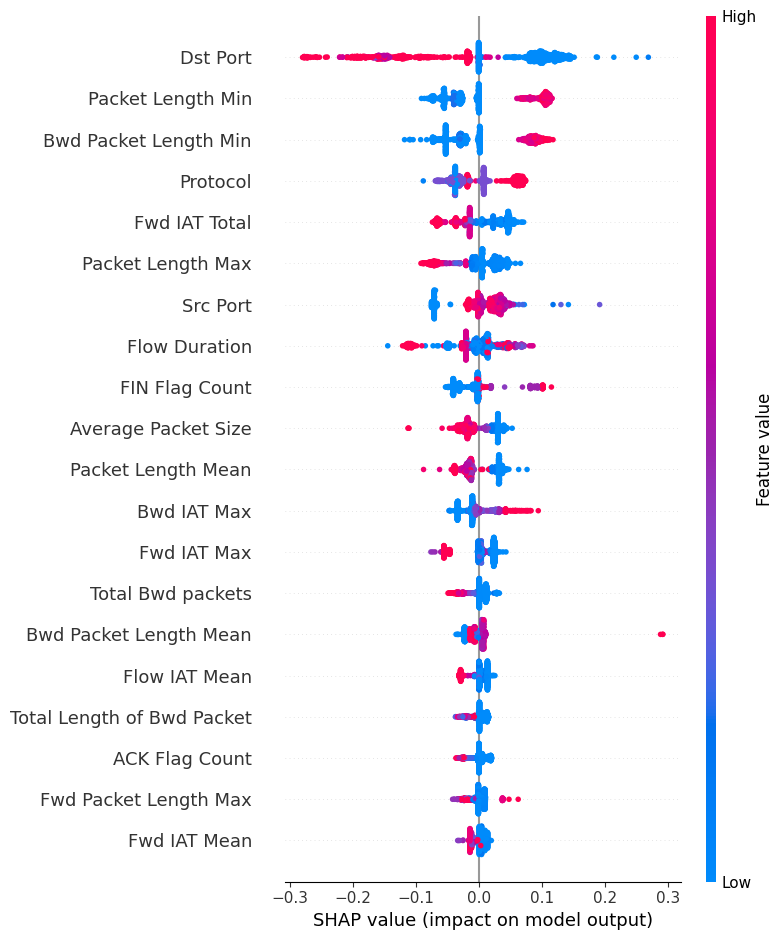


Generating SHAP Dependence Plot for: Src Port


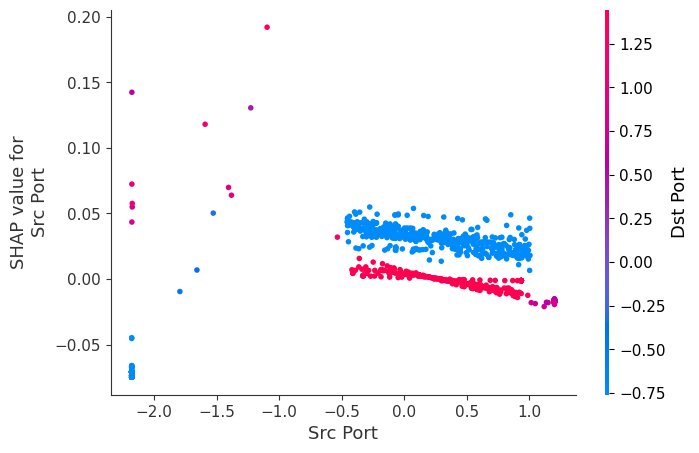

In [108]:
# --- SHAP Value Calculation for CNN ---
warnings.filterwarnings("ignore")
shap.initjs()  # Initialize JS for interactive SHAP plots

# --- Reshape CNN data if not already ---
# Assuming X_train_cnn and X_test_cnn are already reshaped to (samples, features, 1)
# If not, add reshape logic here based on X_scaled_df

# --- Background data for SHAP ---
background_cnn = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 100, replace=False)]

# --- Explicitly build the model before using DeepExplainer ---
# Get the input shape from the training data
input_shape = X_train_cnn.shape[1:]
cnn_model.build((None,) + input_shape) # Build with batch size None

# --- Now SHAP can access model.input and model.output ---
explainer_cnn = shap.DeepExplainer(cnn_model, background_cnn)

# --- Sample test data for SHAP explanation ---
sample_size_shap = 1000
if X_test_cnn.shape[0] > sample_size_shap:
    X_test_cnn_sampled = X_test_cnn[np.random.choice(X_test_cnn.shape[0], sample_size_shap, replace=False)]
else:
    X_test_cnn_sampled = X_test_cnn

print(f"\nCalculating SHAP values for {X_test_cnn_sampled.shape[0]} samples from test set...")

# --- Compute SHAP values ---
try:
    # DeepExplainer returns a list of arrays for multi-output models, but a single array for single-output models.
    # Our model has a single output (sigmoid).
    shap_values_cnn = explainer_cnn.shap_values(X_test_cnn_sampled)

except Exception as e:
    print(f"Error calculating SHAP values: {e}")
    raise

# --- Process SHAP values ---
# If the model is binary classification with sigmoid, shap_values is a list of two arrays.
# We need the SHAP values for the positive class (index 1).
if isinstance(shap_values_cnn, list) and len(shap_values_cnn) == 2:
    shap_values_cnn_processed = np.squeeze(shap_values_cnn[1])
elif isinstance(shap_values_cnn, np.ndarray):
     shap_values_cnn_processed = np.squeeze(shap_values_cnn)
else:
    print("Unexpected SHAP values format.")
    raise ValueError("Unexpected SHAP values format.")


# --- Create DataFrame for plotting ---
# Ensure the DataFrame for plotting has the correct shape (samples, features)
original_feature_names = X_scaled_df.columns.tolist()
# Need to squeeze the sampled test data to match the SHAP values shape for DataFrame creation
X_test_cnn_sampled_squeezed = np.squeeze(X_test_cnn_sampled)

if X_test_cnn_sampled_squeezed.shape[1] != len(original_feature_names):
     # This might happen if the original X_scaled_df had only 1 feature after squeezing
     # or if there's an issue with how features are handled in the CNN input shape.
     # Let's use generic names if original names don't match.
     print("Warning: Squeezed test data shape mismatch with original feature names. Using generic names.")
     cnn_feature_names = [f'CNN_Feature_{i}' for i in range(X_test_cnn_sampled_squeezed.shape[1])]
     X_test_cnn_sampled_df = pd.DataFrame(X_test_cnn_sampled_squeezed, columns=cnn_feature_names)
else:
     X_test_cnn_sampled_df = pd.DataFrame(X_test_cnn_sampled_squeezed, columns=original_feature_names)


# --- Confirm shapes ---
print(f"SHAP values processed shape: {shap_values_cnn_processed.shape}")
print(f"DataFrame for plotting shape: {X_test_cnn_sampled_df.shape}")

# --- SHAP Summary Plot ---
print("\nGenerating SHAP Summary Plot (CNN):")
if shap_values_cnn_processed.shape == X_test_cnn_sampled_df.shape:
    shap.summary_plot(shap_values_cnn_processed, X_test_cnn_sampled_df, feature_names=X_test_cnn_sampled_df.columns)
else:
    print("Shape mismatch for summary plot.")

# --- SHAP Dependence Plot ---
if X_test_cnn_sampled_df.shape[1] > 0:
    # Select a feature to plot - ensure the index is valid
    feature_to_plot_idx = 0 # Index of the first feature
    if feature_to_plot_idx < X_test_cnn_sampled_df.shape[1]:
        feature_to_plot_name = X_test_cnn_sampled_df.columns[feature_to_plot_idx]
        print(f"\nGenerating SHAP Dependence Plot for: {feature_to_plot_name}")
        shap.dependence_plot(feature_to_plot_name, shap_values_cnn_processed, X_test_cnn_sampled_df, interaction_index="auto")
    else:
         print("\nCould not generate Dependence Plot: Feature index out of bounds.")
else:
    print("\nCould not generate Dependence Plot: No features available in DataFrame.")

